# Con Clustering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from typing import Tuple, List
from mlxtend.frequent_patterns import apriori, association_rules

In [32]:
# Sezione 1: Caricamento dati (MovieLens 100k)
url = "../datasets/ml-100k/u.data"
columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df = pd.read_csv(url, sep='\t', names=columns)
df.drop(columns='timestamp', inplace=True)

In [33]:
# Sezione 2: Matrice utente-item e sparsità
ratings_matrix = df.pivot_table(index='user_id', columns='movie_id', values='rating')
n_users, n_items = ratings_matrix.shape
nnz = ratings_matrix.count().sum()
sparsity = 1 - nnz / (n_users * n_items)
print(f"Numero utenti: {n_users}, Numero item: {n_items}")
print(f"Ratings non nulli: {nnz}")
print(f"Sparsità: {sparsity:.2%}")

Numero utenti: 943, Numero item: 1682
Ratings non nulli: 100000
Sparsità: 93.70%


In [34]:
# Sezione 3: Gestione della sparsità con SVD (se necessario)
threshold_sparsity = 0.85
if sparsity > threshold_sparsity:
    # Riempio NaN con zero
    R_filled = ratings_matrix.fillna(0)
    # Creo la matrice sparsa
    R_sparse = sparse.csr_matrix(R_filled.values)
    
    u_svd, s_svd, vt_svd = svds(R_sparse, k=50)
    R_svd = u_svd.dot(np.diag(s_svd)).dot(vt_svd)
    ratings_matrix = pd.DataFrame(R_svd, index=ratings_matrix.index, columns=ratings_matrix.columns)
    nnz_svd = np.count_nonzero(ratings_matrix.values)
    sparsity_svd = 1 - nnz_svd / ratings_matrix.size
    print("SVD applicato: matrice ricostruita densa.")
    print(f"Sparsità dopo SVD: {sparsity_svd:.2%}")
else:
    ratings_matrix = ratings_matrix.fillna(0)
    print("Sparsità accettabile: nessuna SVD necessaria.")

SVD applicato: matrice ricostruita densa.
Sparsità dopo SVD: 0.00%


In [35]:
# Sezione 4: Split train/test e train_matrix
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
train_matrix = train_data.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)

In [36]:
# Sezione 5: Calcolo similarity user/item
sim_cosine_u = cosine_similarity(train_matrix)
# Matrice normalizzata: ogni utente è normalizzato rispetto alla sua media
R_centered = train_matrix.sub(train_matrix.mean(axis=1), axis=0)
sim_pearson_u = 1 - pairwise_distances(R_centered.fillna(0), metric='correlation')
user_similarity = pd.DataFrame(sim_pearson_u, index=train_matrix.index, columns=train_matrix.index)
item_similarity = pd.DataFrame(cosine_similarity(train_matrix.T), index=train_matrix.columns, columns=train_matrix.columns)

In [ ]:
# Sezione 6: Calcolo della migliore combinazione n.di componenti del pca e numero di cluster
def find_best_k_silhouette(R_centered: pd.DataFrame,
                            n_components: int,
                            k_range: range = range(2, 21)
                           ) -> Tuple[int, int, List[float], np.ndarray]:
    # Standardizzazione e PCA
    scaled = StandardScaler().fit_transform(R_centered.fillna(0).values)
    features = PCA(n_components=int(n_components), random_state=42).fit_transform(scaled)
    # Calcolo silhouette per ogni k
    sil_scores = []
    for k in k_range:
        labels = KMeans(n_clusters=k, random_state=42).fit_predict(features)
        sil_scores.append(silhouette_score(features, labels))
    best_k = k_range[np.argmax(sil_scores)]
    return n_components, best_k, sil_scores, features

   PCA comps  best_k  max_silhouette
0          5       2        0.603143
1         10       2        0.566309
2         20       2        0.542790
Setup ottimale: PCA comps = 5.0, k = 2.0


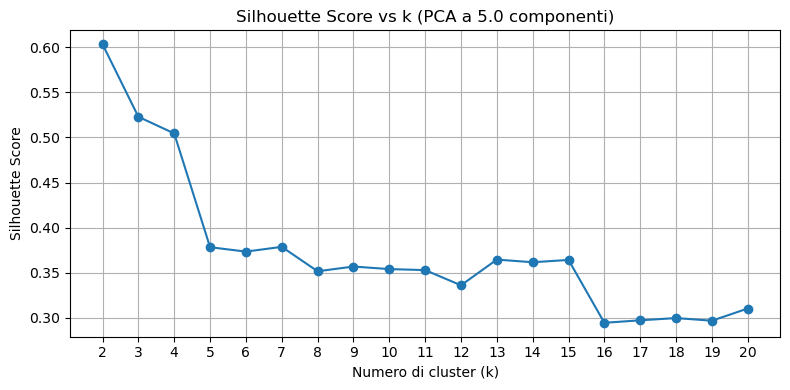

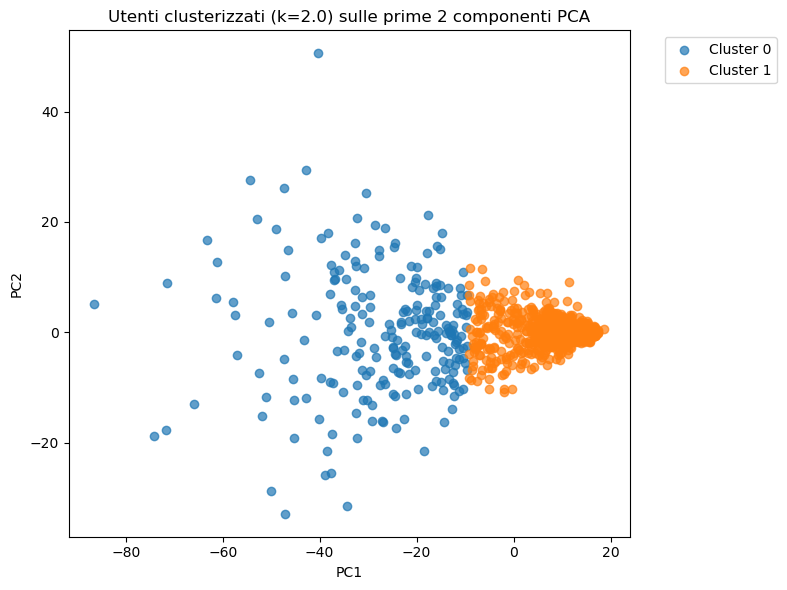

In [ ]:
#Sezione 6.1: Visualizzazione setup ottimale con grafici
# Eseguiamo per 5, 10, 20 componenti
components_list = [5, 10, 20]
results = []
for p in components_list:
    p, k_opt, sil_scores, features_pca = find_best_k_silhouette(R_centered, p)
    results.append({'PCA comps': p, 'best_k': k_opt, 'max_silhouette': max(sil_scores)})

results_df = pd.DataFrame(results)
print(results_df)

# Scelta del setup migliore
best_row = results_df.loc[results_df['max_silhouette'].idxmax()]
p_star, k_star = best_row['PCA comps'], best_row['best_k']
_, _, sil_scores, features_pca = find_best_k_silhouette(R_centered, p_star)
print(f"Setup ottimale: PCA comps = {p_star}, k = {k_star}")

# Plot silhouette score per il setup ottimale
ks = list(range(2, len(sil_scores) + 2))
plt.figure(figsize=(8, 4))
plt.plot(ks, sil_scores, marker='o')
plt.xticks(ks)
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Score vs k (PCA a {p_star} componenti)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Assegna cluster definitivi e salva in una serie per uso futuro
labels_best = KMeans(n_clusters=int(k_star), random_state=42).fit_predict(features_pca)
user_clusters = pd.Series(labels_best, index=train_matrix.index)

# Visualizzazione scatter clusters sulle prime 2 componenti PCA
plt.figure(figsize=(8, 6))
for cid in range(int(k_star)):
    mask = (labels_best == cid)
    plt.scatter(features_pca[mask, 0], features_pca[mask, 1], label=f'Cluster {cid}', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Utenti clusterizzati (k={k_star}) sulle prime 2 componenti PCA')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Sezione 7: Funzioni di predizione CF

# Sogia minima di similarità 
sim_threshold = 0.1
def predict_user_cf(u, i, R, sim, means, clusters):
    same = clusters[clusters == clusters[u]].index
    sims = sim.loc[u, same]
    sims = sims[sims > sim_threshold].sort_values(ascending=False)
    num = den = 0.0
    for v, s in sims.items():
        r = R.loc[v, i] if i in R.columns else 0
        if r > 0:
            num += s * (r - means[v])
            den += abs(s)
    return means[u] if den == 0 else means[u] + num/den

def predict_item_cf(u, i, R, sim, means):
    if i not in sim.index or i not in R.columns:
        return means.get(u, 0)
    sims = sim[i].sort_values(ascending=False)
    num = den = 0.0
    for j, s in sims.items():
        r = R.loc[u, j] if j in R.columns else 0
        if r > 0:
            num += s * (r - means[u])
            den += abs(s)
    return means[u] if den == 0 else means[u] + num/den

user_means = train_matrix.replace(0, np.nan).mean(axis=1).fillna(0)

def hybrid_predict(u, i):
    ub = predict_user_cf(u, i, train_matrix, user_similarity, user_means, user_clusters)
    ib = predict_item_cf(u, i, train_matrix, item_similarity, user_means)
    return 0.5 * ub + 0.5 * ib


In [ ]:
# Sezione 8: Valutazione rating (threshold 3.5 e 4.0)
for threshold in [3.5, 4.0]:
    y_true_bin, y_pred_bin, y_true_cont, y_pred_cont = [], [], [], []
    for _, row in test_data.iterrows():
        u, i, true_r = row.user_id, row.movie_id, row.rating
        pred_r = hybrid_predict(u, i)
        y_true_cont.append(true_r); y_pred_cont.append(pred_r)
        y_true_bin.append(1 if true_r >= threshold else 0)
        y_pred_bin.append(1 if pred_r >= threshold else 0)
    accuracy = accuracy_score(y_true_bin, y_pred_bin)
    precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    mae = mean_absolute_error(y_true_cont, y_pred_cont)
    rmse = np.sqrt(mean_squared_error(y_true_cont, y_pred_cont))
    print(f"Threshold={threshold}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

Threshold=3.5: Accuracy=0.6935, Precision=0.7075, Recall=0.7577, MAE=0.7613, RMSE=0.9606
Threshold=4.0: Accuracy=0.5895, Precision=0.8312, Recall=0.3212, MAE=0.7613, RMSE=0.9606


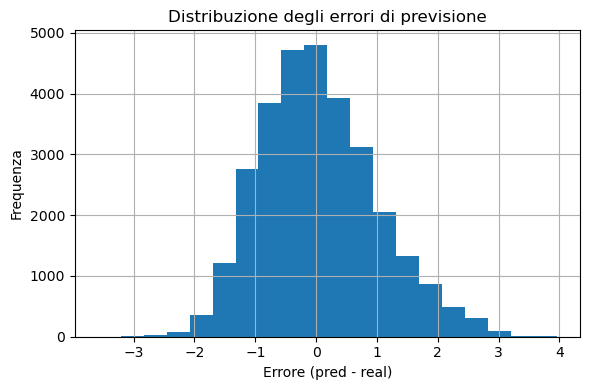

In [ ]:
# Sezione 9: Distribuzione degli errori
ds = pd.DataFrame({'truth': y_true_cont, 'pred': y_pred_cont})
ds['error'] = ds['pred'] - ds['truth']
plt.figure(figsize=(6,4))
ds['error'].hist(bins=20)
plt.xlabel('Errore (pred - real)')
plt.ylabel('Frequenza')
plt.title('Distribuzione degli errori di previsione')
plt.tight_layout()
plt.show()

In [ ]:

# Sezione 10: Costruzione efficiente matrice P_hybrid
user_centered = train_matrix.sub(user_means, axis=0)
# Calcolo vettoriale di P_hybrid
# user-based
den_u = np.abs(user_similarity).sum(axis=1).to_numpy().reshape(-1,1)
P_u = user_similarity.dot(user_centered) / den_u + user_means.to_numpy().reshape(-1,1)
# item-based
den_i = np.abs(item_similarity).sum(axis=1).to_numpy().reshape(1,-1)
P_i = user_centered.dot(item_similarity) / den_i + user_means.to_numpy().reshape(-1,1)
# matrice ibrida
P_hybrid = 0.5 * (P_u + P_i)
# Converti in numpy array per accesso per posizione
P_hybrid = P_hybrid.to_numpy() if hasattr(P_hybrid, 'to_numpy') else P_hybrid

In [ ]:
# Sezione 11.1: Calcolo metriche precision/recal@K con K= 10
k = 10
thresholds = [3.5, 4.0]
results = []

# Mapping user_id -> indice riga e movie_id -> indice colonna
user_to_idx = {uid: idx for idx, uid in enumerate(train_matrix.index)}
movie_to_idx = {mid: idx for idx, mid in enumerate(train_matrix.columns)}
train_items = train_data.groupby('user_id')['movie_id'].apply(set).to_dict()

for threshold in thresholds:
    test_items = test_data[test_data.rating >= threshold].groupby('user_id')['movie_id'].apply(set).to_dict()
    precisions, recalls = [], []

    for u, actual in test_items.items():
        idx = user_to_idx.get(u)
        if idx is None:
            continue

        row = P_hybrid[idx]
        mask = np.ones(row.shape, dtype=bool)
        seen = train_items.get(u, set())
        seen_idx = [movie_to_idx[m] for m in seen if m in movie_to_idx]
        mask[seen_idx] = False

        scores = row[mask]
        if scores.size < k:
            continue

        topk_idx = np.argpartition(-scores, k)[:k]
        candidates = np.arange(row.shape[0])[mask]
        topk_items = set(candidates[topk_idx])

        hits = len(topk_items & {movie_to_idx[m] for m in actual if m in movie_to_idx})
        precisions.append(hits / k)
        recalls.append(hits / len(actual))

    if precisions:
        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        results.append({
            'Threshold': threshold,
            f'Precision@{k}': avg_precision,
            f'Recall@{k}': avg_recall
        })

# Converti in DataFrame
results_df = pd.DataFrame(results)
print(results_df)


   Threshold  Precision@10  Recall@10
0        3.5      0.280021   0.216546
1        4.0      0.280021   0.216546


In [ ]:
# Sezione 11.2: Calcolo metriche precision/recal@K con K= 5
k = 5
thresholds = [3.5, 4.0]
results = []

# Mapping user_id -> indice riga e movie_id -> indice colonna
user_to_idx = {uid: idx for idx, uid in enumerate(train_matrix.index)}
movie_to_idx = {mid: idx for idx, mid in enumerate(train_matrix.columns)}
# Per ogni utente prendo l'insieme di film gia visti nel train
train_items = train_data.groupby('user_id')['movie_id'].apply(set).to_dict()

for threshold in thresholds:
    # Per ogni utente ho quali film gli sono piaciuti davvero nel test set
    test_items = test_data[test_data.rating >= threshold].groupby('user_id')['movie_id'].apply(set).to_dict()
    precisions, recalls = [], []

    # Per ogni utente che ha dei film "piaciuti" nel test set
    for u, actual in test_items.items():
        # Prendo l'indice
        idx = user_to_idx.get(u)
        if idx is None:
            continue

        # Contiene i rating dei film per un utente
        row = P_hybrid[idx]
        mask = np.ones(row.shape, dtype=bool)
        seen = train_items.get(u, set())
        seen_idx = [movie_to_idx[m] for m in seen if m in movie_to_idx]
        # Non considero i film gia visti nel train
        mask[seen_idx] = False

        # Punteggi dei film non visti
        scores = row[mask]
        if scores.size < k:
            continue

        # indici dei top k punteggi
        topk_idx = np.argpartition(-scores, k)[:k]
        # Indici film filtrati
        candidates = np.arange(row.shape[0])[mask]
        # Top k film raccomandati
        topk_items = set(candidates[topk_idx])

        # Quanti film tra quelli suggeriti (Top k) erano effettivamente piaciuti all’utente secondo il test set
        hits = len(topk_items & {movie_to_idx[m] for m in actual if m in movie_to_idx})
        
        # Calcolo Precision Recall
        precisions.append(hits / k)
        recalls.append(hits / len(actual))

    if precisions:
        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        results.append({
            'Threshold': threshold,
            f'Precision@{k}': avg_precision,
            f'Recall@{k}': avg_recall
        })

# Converti in DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Sunto
#1 Per ogni utente:

#2 Prendi i punteggi dei film non ancora visti.

#3 Selezioni i 5 film con punteggio più alto.

#4 Verifichi se quei 5 film erano effettivamente apprezzati nel test.

#5 Calcoli precision/recall su quei 5 film.



   Threshold  Precision@5  Recall@5
0        3.5     0.338889  0.144422
1        4.0     0.338889  0.144422


In [ ]:
# Sezione 12: Tuning peso ibridazione alpha (User vs Item)
# Proviamo diversi pesi alpha per P_hybrid = alpha * P_u + (1-alpha) * P_i
alphas = np.arange(0.0, 1.01, 0.1)
results = []
for alpha in alphas:
    # costruisci ibrido pesato
    P_h = alpha * P_u + (1 - alpha) * P_i
    # se DataFrame, converti in numpy array
    try:
        P_h_arr = P_h.to_numpy()
    except:
        P_h_arr = P_h
    # calcolo precision/recall@10
    precisions_a, recalls_a = [], []
    for u, actual in test_items.items():
        idx = user_to_idx.get(u)
        if idx is None:
            continue
        row = P_h_arr[idx]
        mask = np.ones_like(row, dtype=bool)
        seen_idx = [movie_to_idx[m] for m in train_items.get(u, set()) if m in movie_to_idx]
        mask[seen_idx] = False
        scores = row[mask]
        if scores.size < 10:
            continue
        topk = np.argpartition(-scores, 10)[:10]
        cands = np.arange(row.shape[0])[mask]
        top_items = set(cands[topk])
        hits = len(top_items & {movie_to_idx[m] for m in actual if m in movie_to_idx})
        precisions_a.append(hits / 10)
        recalls_a.append(hits / len(actual))
    if precisions_a:
        results.append((alpha, np.mean(precisions_a), np.mean(recalls_a)))
    else:
        results.append((alpha, None, None))
# Visualizza risultati
cv_df = pd.DataFrame(results, columns=['alpha', 'precision', 'recall'])
print(cv_df)

    alpha  precision    recall
0     0.0   0.004380  0.001806
1     0.1   0.155769  0.132395
2     0.2   0.248718  0.196988
3     0.3   0.277778  0.214244
4     0.4   0.282372  0.217839
5     0.5   0.280021  0.216546
6     0.6   0.277778  0.215373
7     0.7   0.276389  0.214819
8     0.8   0.275000  0.213943
9     0.9   0.274252  0.213611
10    1.0   0.273291  0.213242


In [48]:
def explain_recommendation(u_id: int,
                           recommended_set: set,
                           rules_df: pd.DataFrame,
                           basket: dict) -> List[Tuple[Tuple[int,...], int, float, float, float]]:
    """
    Per ogni regola nelle rules_df, se gli antecedenti della regola
    sono presenti nel basket (film che l'utente ha apprezzato),
    e un consequent è tra i film raccomandati, restituisce una tupla:
    (antecedents, consequent, support, confidence, lift)
    """
    explanations = []
    user_items = set(basket.get(u_id, []))
    
    for _, row_rule in rules_df.iterrows():
        antecedents = set(row_rule['antecedents'])
        consequents = set(row_rule['consequents'])
        # verifico se la regola è “attivabile” dal basket dell’utente
        if antecedents & user_items:
            # per ogni film consequente…
            for c in consequents:
                if c in recommended_set:
                    explanations.append((
                        tuple(antecedents),
                        c,
                        row_rule['support'],
                        row_rule['confidence'],
                        row_rule['lift']
                    ))
    return explanations


In [ ]:
# Sezione 13: Estrazione di regole associative per spiegabilità e potenziamento

#Costruisci matrice transazioni: ogni utente ha un set di film apprezzati (rating >=4)
basket = train_data[train_data.rating >= 4].groupby('user_id')['movie_id'] \
        .apply(lambda x: x.unique().tolist())
# Trasforma in DataFrame one-hot encoding per mlxtend
all_movies = sorted(df.movie_id.unique())
trans_df = pd.DataFrame([{m: (m in movies) for m in all_movies} for movies in basket])
# Calcola itemsets frequenti
frequent_itemsets = apriori(trans_df, min_support=0.05, use_colnames=True)
# Genera regole con lift>=1.2, confidence>=0.6
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)
rules = rules[rules.confidence >= 0.6]

print(f"Numero di regole estratte: {len(rules)}")
print(rules[['antecedents','consequents','support','confidence','lift']].head())

# Esempio di utilizzo: spiega raccomandazione
# Prima, correggiamo mostra_top10_utente per ritornare la lista

def mostra_top10_utente(u_id, P_hybrid, train_data, test_data, movie_to_idx, train_matrix, k=10):
    """
    Restituisce la lista di top-k movie_id consigliati per l'utente u_id.
    """
    if u_id not in train_matrix.index:
        print(f"L'utente {u_id} non è nel train set.")
        return []

    user_idx = train_matrix.index.get_loc(u_id)
    row = P_hybrid[user_idx]

    seen = train_data[train_data.user_id == u_id]['movie_id'].tolist()
    seen_idx = [movie_to_idx[m] for m in seen if m in movie_to_idx]
    mask = np.ones_like(row, dtype=bool)
    mask[seen_idx] = False

    scores = row[mask]
    if scores.size < k:
        print("Utente con pochi film da raccomandare.")
        return []

    topk_idx = np.argpartition(-scores, k)[:k]
    candidates = np.arange(row.shape[0])[mask]
    topk_items_idx = candidates[topk_idx]
    inv_map = {v:k for k,v in movie_to_idx.items()}
    topk_movie_ids = [inv_map[i] for i in topk_items_idx]

    print(f" Utente {u_id}")
    print(f"Top-{k} consigliati: {topk_movie_ids}")

    return topk_movie_ids

# Esempio per utente 42, k=5
user_42_top5 = mostra_top10_utente(42, P_hybrid, train_data, test_data, movie_to_idx, train_matrix, k=5)
exps = explain_recommendation(42, set(user_42_top5), rules, basket)
print("Spiegazioni per utente 42:", exps)


Numero di regole estratte: 75
    antecedents consequents   support  confidence      lift
349        (23)        (98)  0.073248    0.663462  2.550942
416        (88)        (50)  0.058386    0.604396  1.714882
467       (181)        (50)  0.175159    0.606618  1.721186
503       (215)        (50)  0.059448    0.636364  1.805586
517       (250)        (50)  0.053079    0.617284  1.751450
 Utente 42
Top-5 consigliati: [174, 100, 56, 69, 127]
Spiegazioni per utente 42: [((228,), 174, 0.07430997876857749, 0.6194690265486725, 2.493759927388246), ((50, 22), 174, 0.05201698513800425, 0.6125, 2.4657051282051285), ((98, 22), 174, 0.05626326963906582, 0.6385542168674699, 2.5705900525177636), ((172, 22), 174, 0.055201698513800426, 0.6265060240963856, 2.522088353413655), ((181, 22), 174, 0.05626326963906582, 0.6625000000000001, 2.66698717948718), ((50, 195), 174, 0.055201698513800426, 0.6341463414634146, 2.5528455284552845), ((98, 69), 174, 0.055201698513800426, 0.6265060240963856, 2.5220883534136

In [ ]:
# Sezione 14: Confronto valutazione del sistema con e senza augmentation da regole associative
# Creiamo per ogni utente una lista Top-N rule-augmented:
k = 10
augmented_precisions, augmented_recalls = [], []
for u, actual in test_items.items():
    idx = user_to_idx.get(u)
    if idx is None:
        continue
    row = P_hybrid[idx]
    # maschera per film non visti
    mask = np.ones_like(row, dtype=bool)
    seen_idx = [movie_to_idx[m] for m in train_items.get(u, set()) if m in movie_to_idx]
    mask[seen_idx] = False
    scores = row[mask]
    if scores.size < k:
        continue
    # top-k predetti
    topk_idx = np.argpartition(-scores, k)[:k]
    candidates = np.arange(row.shape[0])[mask]
    topk_items = list(candidates[topk_idx])
    # augmentation: premetti consequents di regole rilevanti
    user_basket = set(basket.get(u, []))
    extra = []
    for _, row_rule in rules.iterrows():
        if row_rule['antecedents'].intersection(user_basket):
            for c in row_rule['consequents']:
                if movie_to_idx.get(c) not in seen_idx and movie_to_idx[c] not in topk_items:
                    extra.append(movie_to_idx[c])
    # unisci topk e extra, mantenendo ordine e limito k
    combined = extra + topk_items
    topN = combined[:k]
    # calcolo precision/recall
    hits = len(set(topN) & {movie_to_idx[m] for m in actual if m in movie_to_idx})
    augmented_precisions.append(hits / k)
    augmented_recalls.append(hits / len(actual))
# Risultati
print(f"Augmented Precision@{k}: {np.mean(augmented_precisions):.4f}")
print(f"Augmented Recall@{k}:    {np.mean(augmented_recalls):.4f}")

# Confronto con baseline
print(f"Baseline Precision@{k}: {avg_precision:.4f}")
print(f"Baseline Recall@{k}:    {avg_recall:.4f}")


Augmented Precision@10: 0.2663
Augmented Recall@10:    0.2003
Baseline Precision@10: 0.2800
Baseline Recall@10:    0.2165
